## Pneumothorax segmentation

Data used were taken from https://www.kaggle.com/mnpinto/pneumotorax128

###### Pneumothorax

Imagine suddenly gasping for air, helplessly breathless for no apparent reason. Could it be a collapsed lung? In the future, your entry in this competition could predict the answer.

Pneumothorax can be caused by a blunt chest injury, damage from underlying lung disease, or most horrifying—it may occur for no obvious reason at all. On some occasions, a collapsed lung can be a life-threatening event.

Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. An accurate AI algorithm to detect pneumothorax would be useful in a lot of clinical scenarios. AI could be used to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

The Society for Imaging Informatics in Medicine (SIIM) is the leading healthcare organization for those interested in the current and future use of informatics in medical imaging. Their mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community. Today, they need your help.

##### Import the necessary libraries 

In [6]:
import os, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
from itertools import groupby
from imageio import imread
from random import randint
from tqdm import tqdm_notebook
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K

### Import the data 

In [8]:
TRAIN_SEED = randint(1, 1000)
VALIDATION_SEED = randint(1, 1000)

In [9]:
print(os.listdir("data128"))

['data128', 'masks', 'test', 'train']


In [10]:
train_image_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory(
    "train_data",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = TRAIN_SEED
)


train_mask_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory(
    "train_masks",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = TRAIN_SEED
)

validation_image_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0).flow_from_directory(
    "train_data",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = VALIDATION_SEED,
)

validation_mask_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0).flow_from_directory(
    "train_masks",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = VALIDATION_SEED,
)

Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.


#### Plot the data 

In [11]:
# Function for plotting the masks and images 

def mask_to_rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 1:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1
    return " " + " ".join(rle)

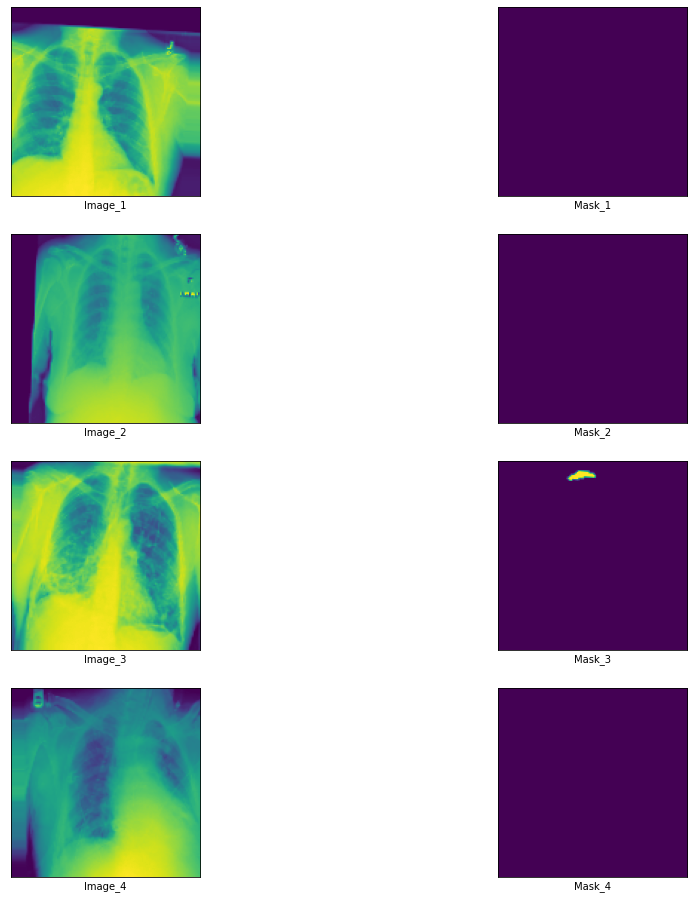

In [12]:
x_batch, _ = train_image_data_generator.next()
y_batch, _ = train_mask_data_generator.next()
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(x_batch[c].reshape(128, 128))
        ax.set_xlabel('Image_' + str(c))
    else:
        ax.imshow(y_batch[c].reshape(128, 128))
        ax.set_xlabel('Mask_' + str(c))
        c += 1
plt.show()

#### Dice Loss

In [13]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Create the Model 

In [14]:
# Create a Unet 

def Unet(shape):
    input_layer = Input(shape = shape) # Takes one argument as input the shape of the image 
    
    
    # Encoding 
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    
    # Decoding 
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3) # Conv2DTranspose is the deconvolution layer 
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

#### Train the model 

In [15]:
model = Unet((128, 128, 1))
model.summary()
model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = [dice_coef, 'binary_accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [16]:
weight_saver = ModelCheckpoint(
    'model.h5',
    monitor = 'val_dice_coeff',
    save_best_only = True,
    mode = 'min',
    save_weights_only = True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5,
    patience = 3, verbose = 1,
    mode = 'min', min_delta = 0.0001,
    cooldown = 2, min_lr = 1e-6
)

early = EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 15
)

In [17]:
def train_data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = train_image_data_generator.next()
        y_batch, _ = train_mask_data_generator.next()
        yield x_batch, y_batch

def validation_data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = validation_image_data_generator.next()
        y_batch, _ = validation_mask_data_generator.next()
        yield x_batch, y_batch

In [19]:
history = model.fit(
    train_data_generator(
        train_image_data_generator,
        train_mask_data_generator
    ),
    epochs = 10,
    steps_per_epoch = 670,
    validation_steps = 670,
    validation_data = validation_data_generator(
        validation_image_data_generator,
        validation_mask_data_generator
    ),
    verbose = 1,
    callbacks = [
        weight_saver,
        early,
        reduce_lr_on_plateau
    ]
)

Epoch 1/10
670/670 [==============================] - 1043s 2s/step - loss: -0.0062 - dice_coef: 0.0062 - binary_accuracy: 0.8795 - val_loss: -0.0064 - val_dice_coef: 0.0064 - val_binary_accuracy: 0.7802
Epoch 2/10
670/670 [==============================] - 1086s 2s/step - loss: -0.0070 - dice_coef: 0.0070 - binary_accuracy: 0.8879 - val_loss: -1.1588e-08 - val_dice_coef: 1.1579e-08 - val_binary_accuracy: 0.9970
Epoch 3/10
670/670 [==============================] - 1073s 2s/step - loss: -1.0697e-07 - dice_coef: 1.0689e-07 - binary_accuracy: 0.9961 - val_loss: -6.8108e-09 - val_dice_coef: 6.8059e-09 - val_binary_accuracy: 0.9970
Epoch 4/10
670/670 [==============================] - ETA: 0s - loss: -5.1476e-08 - dice_coef: 5.1438e-08 - binary_accuracy: 0.9962WARNING:tensorflow:Can save best model only with val_dice_coeff available, skipping.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
670/670 [==============================] - 1079s 2s/step - loss: -5

### Plot the results 

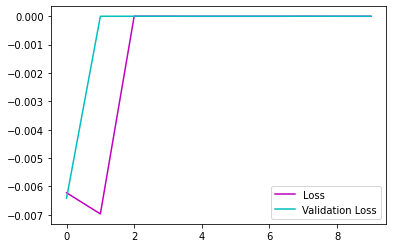

In [22]:
plt.plot(history.history['loss'], color = 'm', label = 'Loss')
plt.plot(history.history['val_loss'], color = 'c', label = 'Validation Loss')
plt.legend()
plt.show()

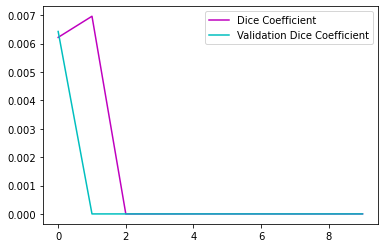

In [23]:
plt.plot(history.history['dice_coef'], color = 'm', label = 'Dice Coefficient')
plt.plot(history.history['val_dice_coef'], color = 'c', label = 'Validation Dice Coefficient')
plt.legend()
plt.show()